In [1]:
#| default_exp normalization

## Within-condition normalization
It is common practice and highly recommended to measure multiple samples of a given condition. This ensures that observed changes between conditions are not just due to random variation. Examples of samples within the same condition could be biological replicates, but also patients with the same clinical condition. 
We want to ensure that systematic changes between within-condition samples are corrected for as follows:

* Our assumed input values are log2 transformed peptide ion intensities, which are stored in a 2d numpy array called "samples". Each row in samples represents a peptide and each column represents a sample

* In a first step, we determine the all pairwise distances between the samples (details explained below)
* We then choose the pair of samples with the closest distance between each other
* We randomly choose one "anchor" sample and one "shift" sample and we subtract the distance between the samples from each peptide intensity measured in the "shift" sample. This is equivalent to rescaling the intensities of the original sample by a constant factor such that the distributions are aligned
* We then construct a virtual "merged" sample by computing the average intensities of anchor and shift sample
* We repeat the steps above until all samples are merged. Keeping track of the shift factors allows us then to determine an ideal shift for each sample



In [2]:
#| export
import numpy as np
import pandas as pd
import time

def get_normfacts(samples):##row is the sample column is the features

    "finds optimal scaling factors for samples measured in the same condition and corrects the samples by these scaling factors. Takes a 2d numpy array as input  "
    set_samples_with_only_single_intensity_to_nan(samples)
    num_samples = samples.shape[0]
    mergedsamples = np.copy(samples) #the virtual "merged" samples will be stored in this array
    sampleidx2shift = dict(zip(range(num_samples), np.zeros(num_samples))) #the scaling factors applied to the samples are stored here
    sampleidx2counts = dict(zip(range(num_samples), np.ones(num_samples)))#keeps track of how many distributions are merged
    sampleidx2anchoridx = {} #keeps track of the shifted samples
    exclusion_set = set() #already clustered samples are stored here
    distance_matrix = create_distance_matrix(samples)
    variance_matrix = create_distance_matrix(samples, metric = 'variance')
    #print(f"distance matrix start\n{distance_matrix}")

    for rep in range(num_samples-1):
        #anchor_idx, shift_idx, min_distance = get_bestmatch_pair(mergedsamples, exclusion_set, sampleidx2counts)
        anchor_idx, shift_idx, min_distance = get_bestmatch_pair(distance_matrix,variance_matrix, sampleidx2counts)
        
        # #determine the closest pair of samples (one "shift" sample to be shifted and one "anchor sample which stays the same") and the distance between this pair
        #update the sets

        if(anchor_idx == None):
            break
        sampleidx2anchoridx.update({shift_idx : anchor_idx})
        sampleidx2shift.update({shift_idx : min_distance })
        exclusion_set.add(shift_idx)

        anchor_sample = mergedsamples[anchor_idx]
        shift_sample = samples[shift_idx]
        shifted_sample = shift_sample + min_distance
        
        merged_sample = merge_distribs(anchor_sample, shifted_sample, sampleidx2counts[anchor_idx], sampleidx2counts[shift_idx])
        mergedsamples[anchor_idx] = merged_sample


        update_distance_matrix(variance_matrix, mergedsamples, anchor_idx, shift_idx, metric='variance')
        update_distance_matrix(distance_matrix, mergedsamples, anchor_idx, shift_idx)

        #print(f"distance matrix after\n{distance_matrix}")
        sampleidx2counts[anchor_idx]+=1

    sampleidx2totalshift = {}
    for i in exclusion_set:
        shift = get_total_shift(sampleidx2anchoridx, sampleidx2shift, i)
        sampleidx2totalshift[i] = shift
        #samples[i] = samples[i]+shift
    return sampleidx2totalshift
    #return samples

def set_samples_with_only_single_intensity_to_nan(samples):
    for idx in range(len(samples)):
        sample = samples[idx]
        if sum(~np.isnan(sample)) <2:
            sample[:] = np.nan
            

def apply_sampleshifts(samples, sampleidx2shift):
    for idx in sampleidx2shift.keys():
        samples[idx] = samples[idx] + sampleidx2shift.get(idx)
    return samples

### Find the best matching pair
Take all pairs of the columns in the "samples" array that have not been already merged and compute the distance between the pairs as follows:
* Subtract sample1 from sample2 (or sample2 from sample1, the order does not matter)
* This results in a distribution of differences. As the samples array contains log2 intensities, this corresponds to taking log2 fold changes
* Take the median of the distribution, this is a good approximation for the change between the two distributions
* Select the two samples with the lowest absolute change

In [3]:
#| export
def get_bestmatch_pair(distance_matrix, variance_matrix, sample2counts):
    
    i,j = np.unravel_index(np.argmin(variance_matrix, axis=None), variance_matrix.shape)
    min_distance = distance_matrix[i,j]
    #print(f"idxs are {i}, {j} median is {distance_matrix[i][j]} variance is {variance_matrix[i][j]}")
    if(min_distance == np.inf):
        return None, None, None
    anchor_idx, shift_idx, min_distance = determine_anchor_and_shift_sample(sample2counts,i, j, min_distance) #direction flip of distance if necessary
    return anchor_idx, shift_idx, min_distance

In [4]:
#| export
def create_distance_matrix(samples, metric = 'median'):
    num_samples = samples.shape[0]
    distance_matrix = np.full((num_samples, num_samples), np.inf)
    for i in range(num_samples):
        for j in range(i+1, num_samples):#do every comparison once
            distance_matrix[i,j] = calc_distance(metric, samples[i], samples[j]) #the median of the shifted distribution is taken as the distance measure
            
    return distance_matrix

In [5]:
#| export
from numba import njit

def calc_distance(metric, samples_1, samples_2):
    res = None

    if metric == 'median':
        res = calc_nanmedian(get_fcdistrib(samples_1, samples_2))#the median of the shifted distribution is taken as the distance measure
    if(metric == 'variance'):
        fcdist = get_fcdistrib(samples_1, samples_2)
        #if sum(~np.isnan(fcdist))<3:
         #   return 1000.0
        res = calc_nanvar(fcdist)
    if metric == 'overlap':
        fcdist = get_fcdistrib(samples_1, samples_2)
        res = sum(~np.isnan(fcdist))
    if res == None:
        raise Exception(f"distance metric {metric} not implemented")
    if(np.isnan(res)):
        return np.inf
    else:
        return res

@njit
def calc_nanvar(fcdist):
    return np.nanvar(fcdist)

@njit
def calc_nanmedian(fcdist):
    return np.nanmedian(fcdist)

In [6]:
#| export
def update_distance_matrix(distance_matrix, merged_samples, merged_sample_idx, shift_idx,metric ='median'):
    "determine the distances to the newly merged sample"
    for i in range(0, merged_sample_idx):#update rows of distance matrix
        if distance_matrix[i, merged_sample_idx]==np.inf:#do not compare already merged samples
            continue
        distance = calc_distance(metric,merged_samples[i], merged_samples[merged_sample_idx])
        distance_matrix[i, merged_sample_idx] = distance
    
    for j in range(merged_sample_idx+1, merged_samples.shape[0]):#update columns of distance matrix
        if distance_matrix[merged_sample_idx, j] == np.inf:
            continue
        distance = calc_distance(metric,merged_samples[merged_sample_idx], merged_samples[j])
        distance_matrix[merged_sample_idx, j] = distance
    
    distance_matrix[shift_idx] = np.inf #shifted samples are excluded by setting distance to infinity
    distance_matrix[:, shift_idx] = np.inf
        

In [7]:
#| export
def get_fcdistrib(logvals_rep1, logvals_rep2):
    "generates difference distribution between two samples"
    dist = np.subtract(logvals_rep1, logvals_rep2)
    return dist

In [8]:
#| export
def determine_anchor_and_shift_sample(sample2counts, i_min, j_min, min_distance):
    "given two samples, declare the sample with fewer merges as the shift"
    counts_i = sample2counts[i_min]
    counts_j = sample2counts[j_min]
    anchor_idx = i_min if counts_i>=counts_j else j_min
    shift_idx = j_min if anchor_idx == i_min else i_min
    flip = 1 if anchor_idx == i_min else -1
    return anchor_idx, shift_idx, flip*min_distance

### Shifting samples
When we have computed the distance between two samples, we want to correct one of the samples by this distance. This results in two distributions with the same median value. We always shift the sample which has been merged from fewer distributions (see below for details). The sample to which the shift is applied is call "shift" sample and the sample which is not shifted is called "anchor" sample.
A "total shift" is calculated after all samples are merged, just by following up how many shifts have been applied to a sample in total

In [9]:
#| export
def shift_samples(samples, sampleidx2anchoridx, sample2shift):
    for sample_idx in range(samples.shape[0]):
        samples[sample_idx] = samples[sample_idx]+get_total_shift(sampleidx2anchoridx, sample2shift, sample_idx)

In [10]:
#| export
def get_total_shift(sampleidx2anchoridx, sample2shift,sample_idx):

    total_shift = 0.0

    while(True):
        total_shift +=sample2shift[sample_idx]
        if sample_idx not in sampleidx2anchoridx: #every shifted sample has an anchor
            break
        sample_idx = sampleidx2anchoridx[sample_idx]

    return total_shift

### Merging distributions
After we shift two distributions on top of each other, we calculate a "merged" distribution. Each intensity in the merged distribution is the average of the intensity in both distributions. For the merging we have to take into account the following: If for example the anchor sample has already been merged from 10 samples, and the shift distribution has not been merged at all, we want to weigh the distribution coming from many samples higher. We hence multiply each sample by the number of merges.

In [11]:
#| export
import time
import numpy as np

def merge_distribs(anchor_distrib, shifted_distrib,counts_anchor_distrib, counts_shifted_distrib):
    "Calculate the average peptide intensities to merge two peptide distributions"

    t_alt = time.time()
    res = np.zeros(len(anchor_distrib))

    nans_anchor = np.isnan(anchor_distrib)
    nans_shifted = np.isnan(shifted_distrib)
    nans_anchor_and_shifted = nans_anchor & nans_shifted
    nans_only_anchor = nans_anchor & ~nans_shifted
    nans_only_shifted = nans_shifted &~nans_anchor
    no_nans = ~nans_anchor & ~nans_shifted

    idx_anchor_and_shifted = np.where(nans_anchor_and_shifted)
    idx_only_anchor = np.where(nans_only_anchor)
    idx_only_shifted = np.where(nans_only_shifted)
    idx_no_nans = np.where(no_nans)

    res[idx_anchor_and_shifted] = np.nan
    res[idx_only_anchor] = shifted_distrib[idx_only_anchor]
    res[idx_only_shifted] = anchor_distrib[idx_only_shifted]
    res[idx_no_nans] = (anchor_distrib[idx_no_nans] *counts_anchor_distrib + shifted_distrib[idx_no_nans]*counts_shifted_distrib)/(counts_anchor_distrib+counts_shifted_distrib)
    return res

## Wrapper functions

In [12]:
#| export
import pandas as pd

def normalize_dataframe_between_samples(ion_dataframe):
    sample2shift = get_normfacts(drop_nas_if_possible(ion_dataframe).to_numpy())
    df_c_normed = pd.DataFrame(apply_sampleshifts(ion_dataframe.to_numpy(), sample2shift), index = ion_dataframe.index, columns = ion_dataframe.columns)
    return df_c_normed

def normalize_ion_profiles(protein_profile_df):
    protein_profile_numpy = protein_profile_df.to_numpy()
    sample2shift = get_normfacts(protein_profile_numpy)
    df_normed = pd.DataFrame(apply_sampleshifts(protein_profile_numpy, sample2shift), index = protein_profile_df.index, columns = protein_profile_df.columns)
    return df_normed


def drop_nas_if_possible(df):
    df_nonans = df.dropna(axis=1)
    fraction_nonans = calculate_fraction_with_no_NAs(df, df_nonans)
    num_nonans = len(df_nonans.columns)
    if num_nonans<1000 or fraction_nonans<0.001:
        print('to few values for normalization without missing values. Including missing values')
        return df
    else:
        return df_nonans

def calculate_fraction_with_no_NAs(df, df_nonnans):
    return len(df_nonnans.columns)/len(df.columns)


In [13]:
#| export
import logging

class NormalizationManager():
    def __init__(self, complete_dataframe, num_samples_quadratic = 100):
        self.complete_dataframe = complete_dataframe
        self._num_samples_quadratic = num_samples_quadratic
        self._rows_sorted_by_number_valid_values = None
        self._quadratic_subset_rows = None
        self._linear_subset_rows = None
        self._merged_reference_sample = None #pd.Series with mean intensity
        self.normalization_function = None

    def _run_normalization(self):
        if len(self.complete_dataframe.index) <= self._num_samples_quadratic:
            self._normalize_complete_input_quadratic()
        else:
            self._normalize_quadratic_and_linear()
    
    def _normalize_complete_input_quadratic(self):
        self.complete_dataframe =  self.normalization_function(self.complete_dataframe)
    
    def _normalize_quadratic_and_linear(self):
        self._determine_subset_rows()
        self._normalize_quadratic_selection()
        self._create_reference_sample()
        self._shift_remaining_dataframe_to_reference_sample()

    def _determine_subset_rows(self):
        self._determine_sorted_rows()
        self._quadratic_subset_rows = self._rows_sorted_by_number_valid_values[:self._num_samples_quadratic]
        self._linear_subset_rows = [x for x in self.complete_dataframe.index if x not in self._quadratic_subset_rows]

    def _determine_sorted_rows(self):
        rows = self.complete_dataframe.index
        self._rows_sorted_by_number_valid_values =  sorted(rows, key= lambda idx : self._get_num_nas_in_row(self.complete_dataframe.loc[idx,:].to_numpy()))

    def _normalize_quadratic_selection(self):
        quadratic_subset_dataframe = self.complete_dataframe.loc[self._quadratic_subset_rows]
        self.complete_dataframe.loc[self._quadratic_subset_rows,:] = self.normalization_function(quadratic_subset_dataframe)
    
    def _create_reference_sample(self):
        quadratic_subset_dataframe = self.complete_dataframe.loc[self._quadratic_subset_rows]
        self._merged_reference_sample = quadratic_subset_dataframe.median(axis=0)
    
    def _shift_remaining_dataframe_to_reference_sample(self):
        linear_subset_dataframe = self.complete_dataframe.loc[self._linear_subset_rows]
        linear_shifted_dataframe = SampleShifterLinear(linear_subset_dataframe, self._merged_reference_sample).ion_dataframe
        self.complete_dataframe.loc[ self._linear_subset_rows, :] = linear_shifted_dataframe
    
    @staticmethod
    @njit
    def _get_num_nas_in_row(row):
        return sum(np.isnan(row))

class NormalizationManagerSamples(NormalizationManager):
    def __init__(self, complete_dataframe, num_samples_quadratic):
        complete_dataframe = complete_dataframe.T #the samples to shift are in each row, therefore the df needs to be transposed
        super().__init__(complete_dataframe, num_samples_quadratic)
        self.normalization_function = normalize_dataframe_between_samples
        self._run_normalization()
        self.complete_dataframe = complete_dataframe.T

class NormalizationManagerSamplesOnSelectedProteins(NormalizationManager):
    def __init__(self, complete_dataframe, num_samples_quadratic, selected_proteins_file = None):
        complete_dataframe = complete_dataframe.T #the samples to shift are in each row, therefore the df needs to be transposed
        super().__init__(complete_dataframe, num_samples_quadratic)
        self.normalization_function = self._normalization_function
        self._selected_proteins_file = selected_proteins_file
        self._selected_protein_groups = None
        self._adapt_selected_proteins_to_protein_groups()
        self._run_normalization()
        self.complete_dataframe = complete_dataframe.T
    
    def _adapt_selected_proteins_to_protein_groups(self):
        if self._selected_proteins_file is not None:
            logging.info('Normalizing only selected proteins')
            selected_proteins = pd.read_csv(self._selected_proteins_file, header=None, sep='\t')[0].to_list()
            protein2proteingroup_mapping = self._get_protein2proteingroup_mapping()
            existing_selected_proteins = [protein for protein in selected_proteins if protein in protein2proteingroup_mapping.keys()]
            self._selected_protein_groups = [protein2proteingroup_mapping[protein] for protein in existing_selected_proteins]
    
    def _get_protein2proteingroup_mapping(self):
        protein_groups = self.complete_dataframe.columns.get_level_values(0).to_list()
        protein2proteingroup_mapping = {protein : protein_group for protein_group in protein_groups for protein in protein_group.split(';')}
        return protein2proteingroup_mapping
   
    def _normalization_function(self, ion_dataframe):
        if self._selected_protein_groups is not None:
            ion_dataframe_selected = ion_dataframe.loc[:,self._selected_protein_groups]
            sample2shift = get_normfacts(ion_dataframe_selected.to_numpy())
        else:
            ion_dataframe_selected = ion_dataframe
            sample2shift = get_normfacts(drop_nas_if_possible(ion_dataframe_selected).to_numpy())

        df_c_normed = pd.DataFrame(apply_sampleshifts(ion_dataframe.to_numpy(), sample2shift), index = ion_dataframe.index, columns = ion_dataframe.columns)
        return df_c_normed
    
    def _create_reference_sample(self):
        quadratic_subset_dataframe = self.complete_dataframe.loc[self._quadratic_subset_rows, self._selected_protein_groups]
        self._merged_reference_sample = quadratic_subset_dataframe.median(axis=0)
    
    def _shift_remaining_dataframe_to_reference_sample(self):
        linear_subset_dataframe = self.complete_dataframe.loc[self._linear_subset_rows]
        linear_shifted_dataframe = SampleShifterLinear(linear_subset_dataframe, self._merged_reference_sample, protein_subset = self._selected_protein_groups).ion_dataframe
        self.complete_dataframe.loc[ self._linear_subset_rows, :] = linear_shifted_dataframe
    

class NormalizationManagerProtein(NormalizationManager):
    def __init__(self, complete_dataframe, num_samples_quadratic):
        super().__init__(complete_dataframe, num_samples_quadratic)
        self.normalization_function = normalize_ion_profiles
        self._rows_sorted_by_number_valid_values = None
        self._run_normalization()

## Shift linear to reference

In [14]:
#| export

class SampleShifterLinearToMedian():
    def __init__(self, ion_dataframe):
        self.ion_dataframe = ion_dataframe
        self._merged_reference_sample = ion_dataframe.median(axis=0)
        self._shift_to_median()
    
    def _shift_to_median(self):
        self.ion_dataframe = SampleShifterLinear(self.ion_dataframe, self._merged_reference_sample).ion_dataframe


In [15]:
#| export
class SampleShifterLinear():
    def __init__(self, ion_dataframe, reference_intensities, protein_subset = None):
        self.ion_dataframe = ion_dataframe
        self._protein_subset = protein_subset
        self._ion_dataframe_values = None
        self._reference_intensities = reference_intensities.to_numpy()
        self._define_ion_dataframe_values()
        self._shift_columns_to_reference_sample()
        #self._update_ion_dataframe()

    def _define_ion_dataframe_values(self):
        if self._protein_subset is not None:
            self._ion_dataframe_values = self.ion_dataframe.loc[: , self._protein_subset].to_numpy()
        else:
            self._ion_dataframe_values = self.ion_dataframe.to_numpy()

    def _shift_columns_to_reference_sample(self):
        num_rows = self._ion_dataframe_values.shape[0]
        for row_idx in range(num_rows):
            self._shift_to_reference_sample(row_idx)
    
    def _shift_to_reference_sample(self, row_idx):
        distance_to_reference = calc_distance(metric='median', samples_1=self._reference_intensities, samples_2=self._ion_dataframe_values[row_idx,:]) #reference-sample = distance
        self.ion_dataframe.iloc[row_idx, :] += distance_to_reference
        #self._ion_dataframe_values[row_idx, :] += distance_to_reference
    
    def _update_ion_dataframe(self):
        self.ion_dataframe.loc[:,:] = self._ion_dataframe_values

## Unit tests

In [16]:
#| include: false
def test_merged_distribs():
    anchor_distrib = np.array([1, 1, 1, 1, 1])
    shift_distrib = np.array([2, 2, 2, 2, 2])
    counts_anchor_distrib = 4
    counts_shifted_distib = 1
    assert (merge_distribs(anchor_distrib, shift_distrib, counts_anchor_distrib, counts_shifted_distib)== np.array([1.2, 1.2, 1.2, 1.2, 1.2])).any()


In [17]:

test_merged_distribs() 

In [18]:
#| include: false
import numpy as np
import pandas as pd


def test_order_of_shifts():
    vals1 = [1, np.nan, 1.5]
    vals2 = [1, 1, np.nan]
    vals3 = [3.2, 1, 2.8]
    vals4 = [4.2, 2, 3.8]
    list_of_vals = [vals1, vals2, vals3, vals4]
    protein_profile_df = create_input_df_from_input_vals(list_of_vals)
    display(protein_profile_df)
    protein_profile_numpy = protein_profile_df.to_numpy()
    sample2shift = get_normfacts(protein_profile_numpy)
    print(sample2shift)
    print(create_distance_matrix(protein_profile_numpy, metric = 'variance'))
    
    df_normed = pd.DataFrame(apply_sampleshifts(protein_profile_numpy, sample2shift), index = protein_profile_df.index, columns = protein_profile_df.columns)
    display(df_normed)

def create_input_df_from_input_vals(list_of_vals):
    index_vals = [("A", f"ion{x}") for x in range(len(list_of_vals))]
    index = pd.Index(index_vals, name=('protein', 'ion'))
    return pd.DataFrame(list_of_vals, index=index)


In [19]:

test_order_of_shifts()

0    1    2
protein ion                
A       ion0  1.0  NaN  1.5
        ion1  1.0  1.0  NaN
        ion2  3.2  1.0  2.8
        ion3  4.2  2.0  3.8

{1: 0.0, 2: -1.2999999999999998, 3: -2.3}
[[   inf 0.     0.2025 0.2025]
 [   inf    inf 1.21   1.21  ]
 [   inf    inf    inf 0.    ]
 [   inf    inf    inf    inf]]


0    1    2
protein ion                
A       ion0  1.0  NaN  1.5
        ion1  1.0  1.0  NaN
        ion2  1.9 -0.3  1.5
        ion3  1.9 -0.3  1.5

In [20]:
#| include: false
def generate_randarrays(number_arrays,size_of_array):
    randarray = []
    for i in range(number_arrays):
        shift = np.random.uniform(low=-10, high=+10)
        randarray.append(np.random.normal(loc=shift, size=size_of_array))
    return np.array(randarray)

In [21]:
#| include: false
import numpy as np
import matplotlib.pyplot as plt

def test_sampleshift(samples):
    num_samples = samples.shape[0]
    merged_sample = []
    for i in range(num_samples):
        plt.hist(samples[i])
        merged_sample.extend(samples[i])
    stdev = np.std(merged_sample)
    print(f"STDev {stdev}")
    assert (stdev <=1.2) 
    
    plt.show()


STDev 1.002632203122283


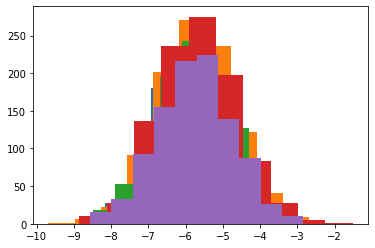

In [22]:

randarray = generate_randarrays(5, 1000)
sample2shift = get_normfacts(randarray)
normalized_randarray = apply_sampleshifts(randarray, sample2shift)
test_sampleshift(normalized_randarray)

In [23]:
#| include: false
import directlfq.utils as lfq_utils
def test_normalizing_between_samples(num_samples_quadratic):
    #input_file = "../test_data/unit_tests/protein_normalization/example_proteins.tsv"
    input_file = "../test_data/system_tests/MaxQuant_boxcar/peptides.txt.maxquant_peptides_benchmarking.aq_reformat.tsv"
    input_df = pd.read_csv(input_file, sep = '\t')
    input_df = lfq_utils.index_and_log_transform_input_df(input_df)
    input_df = input_df[[x for x in input_df.columns if "Shotgun" in x]]
    lfq_utils.plot_withincond_fcs(input_df)
    input_df_normalized = NormalizationManagerSamples(input_df, num_samples_quadratic=num_samples_quadratic).complete_dataframe
    lfq_utils.plot_withincond_fcs(input_df_normalized)


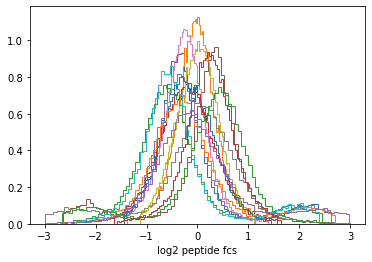

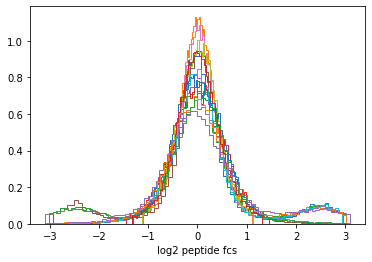

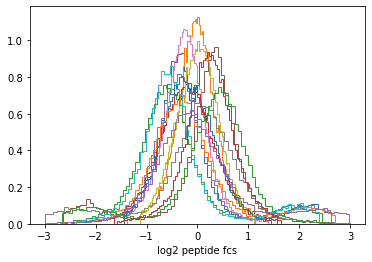

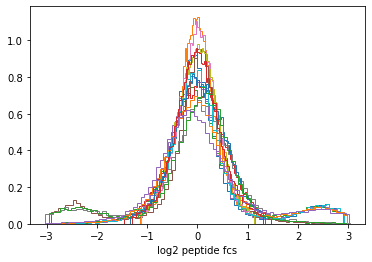

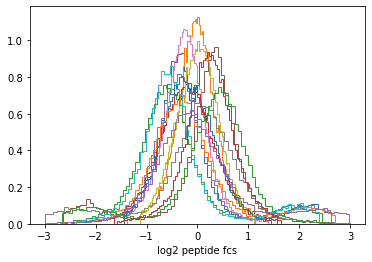

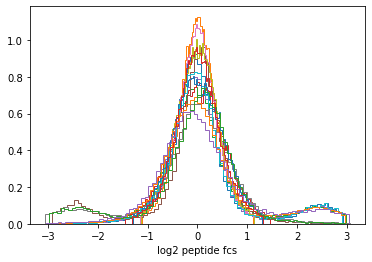

In [24]:

test_normalizing_between_samples(100)
test_normalizing_between_samples(3)
test_normalizing_between_samples(1)

## Learning Tests

In [25]:
import numpy as np
import seaborn as sns

def test_taking_the_mean_along_an_axis():

    example_set = sns.load_dataset("iris").set_index("species")

    example_mean = example_set.mean(axis=1)

    assert example_mean.to_numpy()[3] == np.mean([4.6, 3.1, 1.5, 0.2])


In [26]:

test_taking_the_mean_along_an_axis()